In [1]:
!pip install econml

     |████████████████████████████████| 3.1 MB 241 kB/s            
     |████████████████████████████████| 356 kB 49.0 MB/s            
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 77 kB 4.5 MB/s             
     |████████████████████████████████| 152 kB 47.9 MB/s            
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=544687 sha256=445ef5154401c3539d7f5e36cd9a367244536c5f3536b77d40b93faca179bc5a
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: shap
    Found existing installation: shap 0.40.0
    Uninstalling shap-0.40.0:
      Successfully uninstalled shap-0.40.0


In [2]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor

# EconML imports
from econml.dml import LinearDML, CausalForestDML
from econml.cate_interpreter import SingleTreeCateInterpreter, SingleTreePolicyInterpreter

import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Import the sample pricing data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/Pricing/pricing_sample.csv"
train_data = pd.read_csv(file_url)

In [4]:
train_data.head()

,account_age,age,avg_hours,days_visited,friends_count,has_membership,is_US,songs_purchased,income,price,demand
0,3,53,1.834234,2,8,1,1,4.903237,0.960863,1.0,3.917117
1,5,54,7.171411,7,9,0,1,3.330161,0.732487,1.0,11.585706
2,3,33,5.351920,6,9,0,1,3.036203,1.130937,1.0,24.675960
3,2,34,6.723551,0,8,0,1,7.911926,0.929197,1.0,6.361776
4,4,30,2.448247,5,8,1,0,7.148967,0.533527,0.8,12.624123


In [5]:
#estimator inputs
train_data["log_demand"] = np.log(train_data["demand"])
train_data["log_price"] = np.log(train_data["price"])

Y = train_data["log_demand"].values
T = train_data["log_price"].values
X = train_data[["income"]].values  # features
confounder_names = ["account_age", "age", "avg_hours", "days_visited", "friends_count", "has_membership", "is_US", "songs_purchased"]
W = train_data[confounder_names].values

In [6]:
# Get test data
X_test = np.linspace(0, 5, 100).reshape(-1, 1)
X_test_data = pd.DataFrame(X_test, columns=["income"])

## Create Causal Model 

In [7]:
# initiate an EconML cate estimator
est = LinearDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor(),
              featurizer=PolynomialFeatures(degree=2, include_bias=False))

In [8]:
# fit through dowhy
est_dw = est.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"], feature_names=["income"],
               confounder_names=confounder_names, inference="statsmodels")

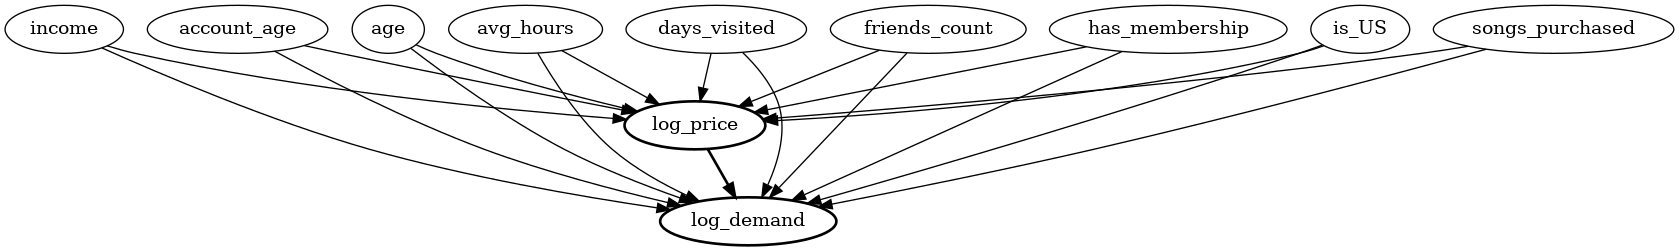

In [9]:
# Visualize causal graph
try:
    # Try pretty printing the graph. Requires pydot and pygraphviz
    display(
        Image(to_pydot(est_dw._graph._graph).create_png())
    )
except:
    # Fall back on default graph view
    est_dw.view_model() 

In [10]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(log_demand|is_US,avg_hours,age,songs_purchased,income
d[log_price]                                                                  

                                                        
,friends_count,has_membership,account_age,days_visited))
                                                        
Estimand assumption 1, Unconfoundedness: If U→{log_price} and U→log_demand then P(log_demand|log_price,is_US,avg_hours,age,songs_purchased,income,friends_count,has_membership,account_age,days_visited,U) = P(log_demand|log_price,is_US,avg_hours,age,songs_purchased,income,friends_count,has_membership,account_age,days_visited)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [11]:
# initiate an EconML cate estimator
est_nonparam = CausalForestDML(model_y=GradientBoostingRegressor(), model_t=GradientBoostingRegressor())
# fit through dowhy
est_nonparam_dw = est_nonparam.dowhy.fit(Y, T, X=X, W=W, outcome_names=["log_demand"], treatment_names=["log_price"],
                                         feature_names=["income"], confounder_names=confounder_names, inference="blb")

# Test Estimate Robustness with DoWhy

## Add Random Common Cause

How robust are our estimates to adding another confounder?

In [12]:
res_random = est_nonparam_dw.refute_estimate(method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.9573995973779295
New effect:-0.95832930881448
p value:0.37



How robust are our estimates to unobserved confounders

In [13]:
res_unobserved = est_nonparam_dw.refute_estimate(
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="linear",
    confounders_effect_on_outcome="linear",
    effect_strength_on_treatment=0.1,
    effect_strength_on_outcome=0.1,
)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:-0.9573995973779295
New effect:-1.010149368734301



## Replace Treatment with a Random (Placebo) Variable


What happens our estimates if we replace the treatment variable with noise?

In [14]:
res_placebo = est_nonparam_dw.refute_estimate(
    method_name="placebo_treatment_refuter", placebo_type="permute", 
    num_simulations=3
)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.9573995973779295
New effect:-0.009779517229192933
p value:0.15574829607146912



## Remove a Random Subset of the Data

Do we recover similar estimates on subsets of the data?

In [15]:
res_subset = est_nonparam_dw.refute_estimate(
    method_name="data_subset_refuter", subset_fraction=0.8, 
    num_simulations=3)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.9573995973779295
New effect:-0.9517490711399156
p value:0.31210482684964586

